# ViEWS 3 ensembles: future predictions

ViEWS monthly updates, cm level Fatalities002 version

This notebook produces future predictions for a set of models defined in the list of dictionaries ModelList, produced by the notebook pgm_constituentmodels in this repository.

The notebook draws on the following .py script files in this repository:

Ensembling.py

FetchData.py

It also requires the list of models included in the ensemble, in the following file:
ModelDefinitions.py

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *
import views_mapper2
from views_mapper2.mapper2 import Mapper2
from views_mapper2 import color
from views_mapper2.label_writer import vid2date
from views_mapper2.dictionary_writer import standard_scale

# Mapper
import geopandas as gpd

import sqlalchemy as sa
#from ingester3.config import source_db_path

# Other packages
import pickle as pkl

#Parallelization
from joblib import Parallel, delayed, cpu_count
from functools import partial


# Packages from this repository, Tools folder
import sys
sys.path.append('../')
sys.path.append('../Tools')
sys.path.append('../Intermediates')
sys.path.append('../SystemUpdates')
import os
from pathlib import Path

# Predicting fatalities scripts
from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated, fetch_df_pg_id_c_id, calibrate_pg_with_c

from FetchData import FetchData, RetrieveFromList, ReturnQsList, index_check
from ViewsEstimators import *

Refreshing


In [3]:
# Common parameters:

dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 517
prod_id = '2022_04_t01'
level = 'pgm'
WriteToOverleaf = False
get_future = True

username = os.getlogin()

depvar = "ln_ged_sb_dep"

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

#steps = [1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,24] # Which steps to train and predict for
#fi_steps = [1,3,6,12,36] # Which steps to present feature importances for
#steps = [1,12,24,36]
fi_steps = [1,3,6,12,36]
#steps = [1,6,36]
#fi_steps = [1,6,36]

# Specifying partitions

calib_partitioner_dict = {"train":(121,408),"predict":(409,456)}
test_partitioner_dict = {"train":(121,456),"predict":(457,504)}
future_partitioner_dict = {"train":(121,504),"predict":(505,516)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

Mydropbox = f'/Users/{username}/Dropbox (ViEWS)/ViEWS/'
localgitpath = f'/Users/{username}/views3/'
notebookpath = os.getcwd()

if WriteToOverleaf:
    if EndOfHistory==508:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    if EndOfHistory==509:
        overleafpath = f'/Users/{username}/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/'
    
    print('Overleaf path set to',overleafpath)

print('Dropbox path set to',Mydropbox)


Dropbox path set to /Users/jim/Dropbox (ViEWS)/ViEWS/


# Retrieve models and predictions

In [4]:
from ModelDefinitions import DefineEnsembleModels

ModelList = DefineEnsembleModels(level)
    
i = 0
for model in ModelList:
    print(i, model['modelname'], model['data_train'])
    i = i + 1

0 fatalities002_pgm_baseline_lgbm baseline
1 fatalities002_pgm_conflictlong_lgbm conflictlong
2 fatalities002_pgm_conflictlong_hurdle_lgbm conflictlong
3 fatalities002_pgm_escwa_drought_hurdle_lgbm escwa_drought
4 fatalities002_pgm_escwa_drought_lgbm escwa_drought
5 fatalities002_pgm_natsoc_hurdle_lgbm natsoc
6 fatalities002_pgm_natsoc_lgbm natsoc
7 fatalities002_pgm_broad_hurdle_lgbm broad
8 fatalities002_pgm_broad_lgbm broad
9 fatalities002_pgm_conflict_history_xgb conflicthist
10 fatalities002_pgm_conflict_treelag_hurdle conflicttreelag
11 fatalities002_pgm_conflict_sptime_dist_hurdle conflictsptime_dist


In [5]:
#gitname = 'EnsembleMetaData_pgm_' + dev_id + '.csv'
#EnsembleMetaData = pd.read_csv(gitname)
#ModelList = EnsembleMetaData.to_dict('records')
#i = 0
#for model in ModelList:
#    print(i, model['modelname'])
#    i = i + 1

# Retrieve and calibrate predictions and data

In [6]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, run_id, level, get_future)

0 fatalities002_pgm_baseline_lgbm
pr_46_pgm_fatalities002_pgm_baseline_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_baseline_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_baseline_lgbm_f517.parquet
1 fatalities002_pgm_conflictlong_lgbm
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_f517.parquet
2 fatalities002_pgm_conflictlong_hurdle_lgbm
pr_46_pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_conflictlong_hurdle_lgbm_f517.parquet
3 fatalities002_pgm_escwa_drought_hurdle_lgbm
pr_46_pgm_fatalities002_pgm_escwa_drought_hurdle_lgbm_calib.parquet
pr_46_pgm_fatalities002_pgm_escwa_drought_hurdle_lgbm_test.parquet
pr_46_pgm_fatalities002_pgm_escwa_drought_hurdle_lgbm_f517.parquet
4 fatalities002_pgm_escwa_drought_lgbm
pr_46_pgm_fatalities002_pgm_escwa_drought_lgbm_calib.

In [7]:
ModelList[0].keys()

dict_keys(['modelname', 'algorithm', 'depvar', 'queryset', 'data_train', 'level', 'preprocessing', 'description', 'long_description', 'predstore_calib', 'predstore_test', 'predictions_calib_df', 'predictions_test_df', 'predictions_future_df'])

In [8]:
qslist = ReturnQsList(level)
from FetchData import fetch_pgm_data_from_model_def

Datasets=fetch_pgm_data_from_model_def(qslist)

 .    
A dataset with 8 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 19 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 29 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 24 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 23 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 30 columns, with data between t 1 and 852. (13110 units)
 .    
A dataset with 8 columns, with data between t 1 and 852. (13110 units)
 .      o   
A dataset with 11 columns, with data between t 1 and 852. (13110 units)
 .    escwa_drought: A dataset with 29 columns, with data between t = 1 and 852; 13110 units.
 .    conflicthist: A dataset with 30 columns, with data between t = 1 and 852; 13110 units.
 .    conflictlong: A dataset with 19 columns, with data between t = 1 and 852; 13110 units.
 .    natsoc: A dataset with 24 columns, with data between t = 1 and 852; 13110 unit

In [9]:
len(Datasets)

8

In [10]:
for model in ModelList:
    print(model['modelname'])
#    print(model['predictions_calib_df'])

fatalities002_pgm_baseline_lgbm
fatalities002_pgm_conflictlong_lgbm
fatalities002_pgm_conflictlong_hurdle_lgbm
fatalities002_pgm_escwa_drought_hurdle_lgbm
fatalities002_pgm_escwa_drought_lgbm
fatalities002_pgm_natsoc_hurdle_lgbm
fatalities002_pgm_natsoc_lgbm
fatalities002_pgm_broad_hurdle_lgbm
fatalities002_pgm_broad_lgbm
fatalities002_pgm_conflict_history_xgb
fatalities002_pgm_conflict_treelag_hurdle
fatalities002_pgm_conflict_sptime_dist_hurdle


In [12]:
calibrate_const_models=False

from views_runs import Storage, StepshiftedModels
from views_partitioning.data_partitioner import DataPartitioner
from viewser import Queryset, Column
from views_runs import operations
from views_runs.run_result import RunResult

RewritePredictions = False # Set this to True to rewrite predictions even if they exist

def RetrainAndPredict(modelname):
    force_retrain = False
    modelstore = storage.Storage()
    # Predictions for true future
    ct = datetime.now()
    print('Future', ct)
    modelstore = storage.Storage()
    model['RunResult_future']  = RunResult.retrain_or_retrieve(
            retrain            = force_retrain,
            store              = modelstore,
            partitioner        = DataPartitioner({"test":future_partitioner_dict}),
            stepshifted_models = StepshiftedModels(model['algorithm'], steps, model['depvar']),
            dataset            = RetrieveFromList(Datasets,model['data_train']),
            queryset_name      = model['queryset'],
            partition_name     = "test",
            timespan_name      = "train",
            storage_name       = model['modelname'] + '_future',
            author_name        = "JED",
    )       
    predictions_future = model['RunResult_future'].run.future_point_predict(EndOfHistory,model['RunResult_future'].data)
    return predictions_future



i = 0
print('Computing predictions, production run ' + prod_id + ', development run ' + run_id)
for model in ModelList:

    # Loop that checks whether (1) this a model trained outside the main system, 
    # (2) retrieves the prediction if it exists in prediction storage,
    # (3) if not checks whether the trained model exists, retrains if not, 
    # Then calibrates the predictions and stores them if they have not been stored before for this run.
    # To do: set the data_preprocessing to the function in the model dictionary
    
#    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    print(i, model['modelname'])

    ct = datetime.now()
    print('Trying to retrieve non-calibrated predictions', ct)
    if RewritePredictions:
        print(model['predstorename_ncal'])
        model['future_df_noncalibrated'] = RetrainAndPredict(model['modelname'])
    else:
        try:
            model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
            print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

        except KeyError:
            print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

    # Calibrating and storing   
    # Storing non-calibrated
        
#    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    print(i, model['modelname'])

    ct = datetime.now()
    print('Trying to retrieve non-calibrated predictions', ct)
    if RewritePredictions:
        model['future_df_noncalibrated'] = RetrainAndPredict(model['modelname'])
    else:
        try:
            model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
            print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

        except KeyError:
            print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

    # Calibrating and storing   
    # Storing non-calibrated
    
#    print('before store',model['future_df_noncalibrated'].index.names)
        
    model['future_df_noncalibrated'].forecasts.set_run(run_id)
    model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True)   
    
#    print('after store',model['future_df_noncalibrated'].index.names)
    
    if calibrate_const_models:
        print('Calibrating')
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
            
        model['future_df_calibrated']['step_combined']=cal_pg_c(model['future_df_calibrated'],cm_predictions_future,'step_combined',df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)    
        # Storing calibrated
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   
            
    i = i + 1

print('All done')
        

Computing predictions, production run 2022_04_t01, development run Fatalities002
0 fatalities002_pgm_baseline_lgbm
Trying to retrieve non-calibrated predictions 2023-03-15 09:37:21.805193
pr_46_pgm_fatalities002_pgm_baseline_lgbm_f517.parquet
Predictions for  pgm_fatalities002_pgm_baseline_lgbm_f517 , run Fatalities002 exist, retrieving from prediction storage
0 fatalities002_pgm_baseline_lgbm
Trying to retrieve non-calibrated predictions 2023-03-15 09:37:26.129152
pr_46_pgm_fatalities002_pgm_baseline_lgbm_f517.parquet
Predictions for  pgm_fatalities002_pgm_baseline_lgbm_f517 , run Fatalities002 exist, retrieving from prediction storage
1 fatalities002_pgm_conflictlong_lgbm
Trying to retrieve non-calibrated predictions 2023-03-15 09:37:41.073217
pr_46_pgm_fatalities002_pgm_conflictlong_lgbm_f517.parquet
Predictions for  pgm_fatalities002_pgm_conflictlong_lgbm_f517 , run Fatalities002 exist, retrieving from prediction storage
1 fatalities002_pgm_conflictlong_lgbm
Trying to retrieve non-

In [13]:
EnsembleList = [] # Separate list of dictionaries for ensembles!

Ensemble = {
    'modelname':            'ensemble_cm_calib',
    'algorithm':            [],
    'depvar':               depvar,
    'data_train':           [],
    'Algorithm_text':       '',
    'calibration_gams':     [],
    'future_df_calibrated': [],
}
EnsembleList.append(Ensemble)



In [14]:
cm_ensemble=ViewsMetadata().with_name('cm_genetic_ensemble_f'+str(EndOfHistory)).fetch()

In [15]:
calib_run_id=int(cm_ensemble['runs_id'].values[0])

In [16]:
cm_predictions_calib = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_ensemble_genetic_calib')
cm_predictions_test = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_ensemble_genetic_test')
cm_predictions_future = pd.DataFrame.forecasts.read_store(run=calib_run_id, name='cm_genetic_ensemble_f'+str(EndOfHistory))

pr_46_cm_ensemble_genetic_calib.parquet
pr_46_cm_ensemble_genetic_test.parquet
pr_46_cm_genetic_ensemble_f517.parquet


In [68]:
cm_predictions_calib

ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
397      1                 0.00000          0.0          0.0          0.0   
         2                 0.00000          0.0          0.0          0.0   
         3                 0.00000          0.0          0.0          0.0   
         4                 0.00000          0.0          0.0          0.0   
         5                 0.00000          0.0          0.0          0.0   
...                            ...          ...          ...          ...   
444      242               0.00000          0.0          0.0          0.0   
         243               0.00000          0.0          0.0          0.0   
         244               0.00000          0.0          0.0          0.0   
         245               0.00000          0.0          0.0          0.0   
         246               2.70805          0.0          0.0          0.0   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
397      1                   0.0          0.0          0.0          0.0   
         2                   0.0          0.0          0.0          0.0   
         3                   0.0          0.0          0.0          0.0   
         4                   0.0          0.0          0.0          0.0   
         5                   0.0          0.0          0.0          0.0   
...                          ...          ...          ...          ...   
444      242                 0.0          0.0          0.0          0.0   
         243                 0.0          0.0          0.0          0.0   
         244                 0.0          0.0          0.0          0.0   
         245                 0.0          0.0          0.0          0.0   
         246                 0.0          0.0          0.0          0.0   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
397      1                   0.0          0.0  ...           0.0   
         2                   0.0          0.0  ...           0.0   
         3                   0.0          0.0  ...           0.0   
         4                   0.0          0.0  ...           0.0   
         5                   0.0          0.0  ...           0.0   
...                          ...          ...  ...           ...   
444      242                 0.0          0.0  ...           0.0   
         243                 0.0          0.0  ...           0.0   
         244                 0.0          0.0  ...           0.0   
         245                 0.0          0.0  ...           0.0   
         246                 0.0          0.0  ...           0.0   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
397      1                    0.0           0.0           0.0           0.0   
         2                    0.0           0.0           0.0           0.0   
         3                    0.0           0.0           0.0           0.0   
         4                    0.0           0.0           0.0           0.0   
         5                    0.0           0.0           0.0           0.0   
...                           ...           ...           ...           ...   
444      242                  0.0           0.0           0.0           0.0   
         243                  0.0           0.0           0.0           0.0   
         244                  0.0           0.0           0.0           0.0   
         245                  0.0           0.0           0.0           0.0   
         246                  0.0           0.0           0.0           0.0   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                

In [17]:
stepcols=['step_pred_' + str(step) for step in steps]

In [64]:
n_models = len(ModelList)

targetcalib=ModelList[0]['predictions_calib_df'][depvar]
targettest=ModelList[0]['predictions_test_df'][depvar]

valscalib=ModelList[0]['predictions_calib_df'][stepcols].values.copy()
valstest=ModelList[0]['predictions_test_df'][stepcols].values.copy()
valsfuture=ModelList[0]['future_df_noncalibrated'].values.copy()

trimmed_calib=ModelList[0]['predictions_calib_df'][stepcols].copy()
index_calib=trimmed_calib.index
columns_calib=trimmed_calib.columns

trimmed_test=ModelList[0]['predictions_test_df'][stepcols].copy()
index_test=trimmed_test.index
columns_test=trimmed_test.columns

trimmed_future=ModelList[0]['future_df_noncalibrated'].copy()
index_future=trimmed_future.index
columns_future=trimmed_future.columns

for model in ModelList[1:]:
    print('adding',model['modelname'])

    valscalib+=model['predictions_calib_df'][stepcols].values.copy()
    valstest+=model['predictions_test_df'][stepcols].values.copy()
    valsfuture+=model['future_df_noncalibrated'].values.copy()

    valscalib/=n_models
    valstest/=n_models
    valsfuture/=n_models

    Ensemble['predictions_calib_df']=pd.DataFrame(data=valscalib, index=index_calib, columns=columns_calib)
    Ensemble['predictions_test_df']=pd.DataFrame(data=valstest, index=index_test, columns=columns_test)
    Ensemble['predictions_future_df']=pd.DataFrame(data=valsfuture, index=index_future, columns=columns_future)
    
df_pg_id_c_id=fetch_df_pg_id_c_id()
    
for col in stepcols:

    thisstep=int(''.join([''+str(f) for f in filter(str.isdigit, col)]))
    thismonth = EndOfHistory + thisstep

#    Ensemble['predictions_calib_df'][col]=calibrate_pg_with_c(Ensemble['predictions_calib_df'],cm_predictions_calib,col,df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)

#    Ensemble['predictions_test_df'][col]=calibrate_pg_with_c(Ensemble['predictions_test_df'],cm_predictions_test,col,df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)
    
future_calib=calibrate_pg_with_c(Ensemble['predictions_future_df'],cm_predictions_future,'step_combined',df_pg_id_c_id=df_pg_id_c_id,log_feature=True,super_calibrate=False)    
    
Ensemble['predictions_future_df']['step_combined']=future_calib['step_combined']

adding fatalities002_pgm_conflictlong_lgbm
adding fatalities002_pgm_conflictlong_hurdle_lgbm
adding fatalities002_pgm_escwa_drought_hurdle_lgbm
adding fatalities002_pgm_escwa_drought_lgbm
adding fatalities002_pgm_natsoc_hurdle_lgbm
adding fatalities002_pgm_natsoc_lgbm
adding fatalities002_pgm_broad_hurdle_lgbm
adding fatalities002_pgm_broad_lgbm
adding fatalities002_pgm_conflict_history_xgb
adding fatalities002_pgm_conflict_treelag_hurdle
adding fatalities002_pgm_conflict_sptime_dist_hurdle
 .    0 518
value_month_cm 0.00584571003298473
value_month_cm 0.042737281373557146
value_month_cm 0.07283804721587006
value_month_cm 0.004927660380682264
value_month_cm 229.18756397237547
value_month_cm 0.02423957568142443
value_month_cm 0.14330059843452592
value_month_cm 49.62148362736865
value_month_cm 0.767190789968262
value_month_cm 0.004706350142324123
value_month_cm 0.027606513255601373
value_month_cm 0.4629617591358117
value_month_cm 0.02454681174657214
value_month_cm 107.64035946560114
value

value_month_cm 4.6887564352929765
value_month_cm 203.95819648500438
value_month_cm 3.4321796145513748
value_month_cm 1.2147881627515194
value_month_cm 5.205850867948924
value_month_cm 0.49114392356216996
value_month_cm 0.33039062900878635
value_month_cm 0.02357981599292991
value_month_cm 4.418730072287269
value_month_cm 1.0854867212800805
max normalised 59.17758574462674 59.17758574462674
3 521
value_month_cm 0.007614043694126327
value_month_cm 0.07684091384697522
value_month_cm 0.09668967069619527
value_month_cm 0.004698964975734743
value_month_cm 398.35485758807806
value_month_cm 0.0453920865506896
value_month_cm 0.22632470393585846
value_month_cm 78.0950672974218
value_month_cm 0.9518837073362476
value_month_cm 0.004631025744480377
value_month_cm 0.039528253462284724
value_month_cm 0.7541817453569006
value_month_cm 0.04913765952032634
value_month_cm 58.35387546700015
value_month_cm 55.939050090321665
value_month_cm 0.04306984485216092
value_month_cm 0.49595172990847414
value_month_c

value_month_cm 6.749116256604664
value_month_cm 0.5372752849507039
value_month_cm 0.506860960617542
value_month_cm 0.02860202979955151
value_month_cm 3.8271439025929475
value_month_cm 1.0017205551600359
max normalised 49.7996587116659 62.39719212207188
6 524
value_month_cm 0.016390610849748022
value_month_cm 0.14769555398447665
value_month_cm 0.26378464145196734
value_month_cm 0.009338577026134276
value_month_cm 328.09828363995524
value_month_cm 0.11838845080375182
value_month_cm 0.19003196121067423
value_month_cm 58.035436182401945
value_month_cm 0.9992370358300053
value_month_cm 0.008013192742397868
value_month_cm 0.08805075043657506
value_month_cm 0.6274725837844588
value_month_cm 0.07105027402392894
value_month_cm 212.22648877423322
value_month_cm 94.0846848979349
value_month_cm 0.05360462027077295
value_month_cm 0.39098823635811963
value_month_cm 29.736182103546316
value_month_cm 20.121411449940858
value_month_cm 0.4491600628742045
value_month_cm 0.9671403023369032
value_month_cm 

value_month_cm 1.9486456926534452
max normalised 39.537828935992906 62.39719212207188
9 527
value_month_cm 0.03864441529711282
value_month_cm 0.19478179108140337
value_month_cm 0.17873449554451892
value_month_cm 0.017687203859102052
value_month_cm 213.62213861119017
value_month_cm 0.28033312956134626
value_month_cm 0.20930735545834178
value_month_cm 45.59354466072817
value_month_cm 0.673715400044363
value_month_cm 0.017348743660541288
value_month_cm 0.06337265371442258
value_month_cm 0.5280312674292911
value_month_cm 0.06234852651319267
value_month_cm 355.7507969912578
value_month_cm 66.65014556696184
value_month_cm 0.05218602670255823
value_month_cm 0.6813346974953578
value_month_cm 24.05478303979422
value_month_cm 14.966491057272872
value_month_cm 0.5630604118663904
value_month_cm 1.0876152845350884
value_month_cm 0.09597118363081303
value_month_cm 25.465504523837723
value_month_cm 423.8251367845503
value_month_cm 0.23774084348507807
value_month_cm 1.963298205673171
value_month_cm 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.2136351193866064
value_month_cm 0.02761637934349226
value_month_cm 219.08837677018371
value_month_cm 0.09382531892123613
value_month_cm 0.2263097507586167
value_month_cm 57.695980744134424
value_month_cm 1.227975942670708
value_month_cm 0.023346149389714688
value_month_cm 0.0749430594771805
value_month_cm 0.34194351896461095
value_month_cm 0.0737245381490399
value_month_cm 80.14419110044203
value_month_cm 65.85346583276116
value_month_cm 0.08562202228456384
value_month_cm 0.7249870337044513
value_month_cm 28.134245725925638
value_month_cm 10.636538760001326
value_month_cm 0.31797346944765836
value_month_cm 1.5933213319487698
value_month_cm 0.06722666132247834
value_month_cm 37.47451891114048
value_month_cm 352.54333405934597
value_month_cm 0.15022523649572372
value_month_cm 2.235853749398108
value_month_cm 0.06103344317387682
value_month_cm 0.03921833417717324
value_month_cm 0.08096871568596975
value_month_cm 0.1809945644029578
value_month_cm 8.408128848242646
value_month_cm 0.096308

value_month_cm 1.1389713363398704
value_month_cm 0.025183530910585228
value_month_cm 0.07675916090165469
value_month_cm 0.4328806351415111
value_month_cm 0.08773421990672281
value_month_cm 97.17267460050674
value_month_cm 89.97134278979796
value_month_cm 0.1222749143398072
value_month_cm 0.6435724557519993
value_month_cm 41.2662909028927
value_month_cm 12.857974988017341
value_month_cm 0.31858266546059566
value_month_cm 0.9576913834876912
value_month_cm 0.06474428624265105
value_month_cm 25.88162836457221
value_month_cm 336.2150356491833
value_month_cm 0.18756727378448446
value_month_cm 1.3896819502970597
value_month_cm 0.04913098270171434
value_month_cm 0.04144404485437603
value_month_cm 0.055547915087522215
value_month_cm 0.3005728388705722
value_month_cm 7.057098419985081
value_month_cm 0.10049708275768632
value_month_cm 505.15115965132884
value_month_cm 0.09516409600948528
value_month_cm 582.9055727385146
value_month_cm 0.18090639113283635
value_month_cm 1.3219275575247837
value_mo

value_month_cm 95.36193876296117
value_month_cm 0.2852260335671164
value_month_cm 0.7847890828776813
value_month_cm 44.79284220535902
value_month_cm 9.528047522772258
value_month_cm 0.33374983463972985
value_month_cm 1.9402091399994834
value_month_cm 0.12626160106326445
value_month_cm 42.862408173506495
value_month_cm 303.65184315266487
value_month_cm 0.1523879327162423
value_month_cm 1.6122299788461492
value_month_cm 0.06984465802232864
value_month_cm 0.05471964186546585
value_month_cm 0.09306586868759625
value_month_cm 0.4553056385770513
value_month_cm 12.282040042440595
value_month_cm 0.21994911361994585
value_month_cm 368.79345215074045
value_month_cm 0.100863915760939
value_month_cm 724.8422874056472
value_month_cm 0.2578081013079039
value_month_cm 1.3981089721684623
value_month_cm 0.056803941726503826
value_month_cm 4.859385023605759
value_month_cm 0.10498030890187193
value_month_cm 0.06134272785068995
value_month_cm 0.6067553896216908
value_month_cm 0.2104662518985123
value_mont

value_month_cm 0.6993739236303609
value_month_cm 76.04311712942783
value_month_cm 275.6648553732408
value_month_cm 0.26106952945477224
value_month_cm 1.7269383096278368
value_month_cm 0.14771061478207703
value_month_cm 0.07579479596057248
value_month_cm 0.44114177683628064
value_month_cm 0.4211213983907436
value_month_cm 9.5547698424815
value_month_cm 0.23538384505113275
value_month_cm 470.8671370916732
value_month_cm 0.14404920279633138
value_month_cm 477.0972963157614
value_month_cm 0.2449777398312465
value_month_cm 0.920428517811587
value_month_cm 0.08605849599837079
value_month_cm 4.894890110843174
value_month_cm 0.10015984565396896
value_month_cm 0.08456619014697075
value_month_cm 0.7410897929288729
value_month_cm 0.14543325055602696
value_month_cm 374.8870790956412
value_month_cm 308.61677062916925
value_month_cm 0.06706519114457832
value_month_cm 2.5238287891867204
value_month_cm 0.7121746275797425
value_month_cm 1.219514164199794
value_month_cm 0.3642389924196441
value_month_cm

value_month_cm 0.07644757268050006
value_month_cm 0.6896909868299468
value_month_cm 10.007664334284454
value_month_cm 0.21279760064551723
value_month_cm 456.8110615282632
value_month_cm 0.13387972425482508
value_month_cm 690.1456156090196
value_month_cm 0.4217313853583071
value_month_cm 1.8940197072300462
value_month_cm 0.07201253530968454
value_month_cm 5.047965402587156
value_month_cm 0.16637456621582514
value_month_cm 0.07852158374995888
value_month_cm 0.743699366006306
value_month_cm 0.1564479040149256
value_month_cm 347.16773211853837
value_month_cm 267.5202838246041
value_month_cm 0.06255921036270329
value_month_cm 2.906485652616434
value_month_cm 0.9258400432384324
value_month_cm 1.8950110074755795
value_month_cm 0.1925547029014878
value_month_cm 0.08618508452157969
value_month_cm 0.045744853233093075
value_month_cm 0.22103625068949473
value_month_cm 75.8151953558497
value_month_cm 0.17296960280238505
value_month_cm 0.2970891397165658
value_month_cm 0.3659103406506574
value_mont

value_month_cm 0.5267464644412281
value_month_cm 1.5303613425707616
value_month_cm 0.09571478211080531
value_month_cm 5.778683687496318
value_month_cm 0.18208922004039652
value_month_cm 0.09684416488281156
value_month_cm 1.06903087089748
value_month_cm 0.16419949860756877
value_month_cm 670.6986568658871
value_month_cm 231.78229047714325
value_month_cm 0.06503710098401161
value_month_cm 2.8925235967513028
value_month_cm 1.6860150853082438
value_month_cm 1.6326356824323365
value_month_cm 0.20183042473594437
value_month_cm 0.08845511217954005
value_month_cm 0.045566697008728285
value_month_cm 0.1974482941161544
value_month_cm 107.58716697016983
value_month_cm 0.2085102775188914
value_month_cm 0.37069555937252296
value_month_cm 0.47029619285163493
value_month_cm 0.7908891817784496
value_month_cm 177.05952978103142
value_month_cm 0.0945825811080152
value_month_cm 0.11659163590105881
value_month_cm 2.9393961575783853
value_month_cm 0.05396698867432548
value_month_cm 0.043209389048305624
val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




value_month_cm 90.67287626020163
value_month_cm 0.28240821976660757
value_month_cm 0.5390788259239414
value_month_cm 81.4832677434654
value_month_cm 1.1548893829154085
value_month_cm 0.06668433494717463
value_month_cm 0.17561328678236698
value_month_cm 0.9345596709279509
value_month_cm 0.33751000186922475
value_month_cm 36.42991189672707
value_month_cm 137.02692346465602
value_month_cm 0.5239766012958404
value_month_cm 1.5097773169721682
value_month_cm 44.95964584514027
value_month_cm 15.443259838598092
value_month_cm 0.7059452670508795
value_month_cm 2.1544626282617867
value_month_cm 0.15064855761811602
value_month_cm 41.46157419088461
value_month_cm 156.66315373862926
value_month_cm 0.3682720911576336
value_month_cm 1.945433838804841
value_month_cm 0.11972653489601126
value_month_cm 0.14299095387519878
value_month_cm 0.10061031568814638
value_month_cm 1.727167079283118
value_month_cm 14.738924744860007
value_month_cm 0.23477055510548506
value_month_cm 368.72433509690313
value_month_

KeyboardInterrupt: 

In [57]:
Ensemble['predictions_calib_df'].describe()

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_27,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36
count,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,...,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000
mean,0.001295,0.001241,0.001211,0.001165,0.001162,0.001139,0.001116,0.001087,0.001105,0.001061,...,0.000730,0.000716,0.000697,0.000672,0.000661,0.000667,0.000657,0.000652,0.000633,0.000634
std,0.009265,0.008504,0.008375,0.007650,0.007507,0.007299,0.006968,0.006832,0.007023,0.006666,...,0.004068,0.003972,0.003743,0.003614,0.003513,0.003525,0.003445,0.003348,0.003198,0.003152
min,0.000006,0.000009,0.000009,0.000006,0.000010,0.000009,0.000009,0.000007,0.000009,0.000009,...,0.000008,0.000009,0.000009,0.000010,0.000010,0.000009,0.000008,0.000008,0.000008,0.000011
25%,0.000023,0.000031,0.000032,0.000039,0.000039,0.000037,0.000038,0.000041,0.000042,0.000045,...,0.000049,0.000052,0.000052,0.000053,0.000052,0.000052,0.000051,0.000053,0.000054,0.000057
50%,0.000048,0.000062,0.000066,0.000073,0.000078,0.000074,0.000079,0.000079,0.000082,0.000085,...,0.000096,0.000101,0.000103,0.000102,0.000099,0.000101,0.000103,0.000105,0.000104,0.000107
75%,0.000156,0.000170,0.000184,0.000183,0.000198,0.000201,0.000207,0.000208,0.000212,0.000224,...,0.000281,0.000271,0.000258,0.000252,0.000252,0.000264,0.000258,0.000264,0.000262,0.000262
max,0.198766,0.195938,0.191946,0.165018,0.165836,0.164042,0.162425,0.165351,0.186463,0.192960,...,0.138473,0.168041,0.139503,0.129915,0.120357,0.147680,0.121557,0.121201,0.127083,0.115028


In [46]:
Ensemble['predictions_test_df'].describe()

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_27,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36
count,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,...,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000,629280.000000
mean,0.001609,0.001589,0.001562,0.001566,0.001540,0.001545,0.001498,0.001499,0.001507,0.001485,...,0.001257,0.001231,0.001227,0.001217,0.001238,0.001230,0.001220,0.001208,0.001202,0.001195
std,0.011178,0.010684,0.010303,0.010072,0.009723,0.009499,0.008905,0.008971,0.008861,0.008635,...,0.006023,0.005749,0.005771,0.005779,0.006014,0.006015,0.005870,0.005983,0.005830,0.005735
min,0.000006,0.000007,0.000007,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,...,0.000011,0.000010,0.000010,0.000013,0.000014,0.000011,0.000015,0.000016,0.000016,0.000013
25%,0.000023,0.000029,0.000033,0.000036,0.000041,0.000040,0.000043,0.000047,0.000050,0.000050,...,0.000068,0.000070,0.000069,0.000072,0.000071,0.000073,0.000072,0.000075,0.000079,0.000080
50%,0.000048,0.000059,0.000063,0.000070,0.000075,0.000079,0.000088,0.000090,0.000094,0.000101,...,0.000151,0.000156,0.000157,0.000160,0.000158,0.000171,0.000176,0.000176,0.000170,0.000165
75%,0.000180,0.000199,0.000224,0.000227,0.000246,0.000257,0.000268,0.000287,0.000296,0.000309,...,0.000495,0.000489,0.000489,0.000491,0.000483,0.000515,0.000521,0.000507,0.000512,0.000528
max,0.319246,0.305496,0.294863,0.254687,0.249029,0.254141,0.237042,0.218657,0.236229,0.238582,...,0.148494,0.142754,0.134652,0.138827,0.140833,0.137493,0.126913,0.140978,0.153443,0.135421


In [47]:
Ensemble['predictions_future_df'].describe()

feature,step_combined
count,471960.000000
mean,0.096832
std,0.350701
min,0.000015
25%,0.000859
50%,0.003524
75%,0.022967
max,5.834877


In [19]:
ModelList[1].keys()

dict_keys(['modelname', 'algorithm', 'depvar', 'queryset', 'data_train', 'level', 'preprocessing', 'description', 'long_description', 'predstore_calib', 'predstore_test', 'predictions_calib_df', 'predictions_test_df', 'predictions_future_df', 'predstorename_ncal', 'predstorename_cal', 'future_df_noncalibrated'])

In [20]:
Ensemble['predictions_calib_df'][depvar]=targetcalib
Ensemble['predictions_test_df'][depvar]=targettest

In [21]:
# Save ensemble predictions
predstore_calib = level +  '_' + Ensemble['modelname'] + '_calib'
Ensemble['predictions_calib_df'].forecasts.set_run(run_id)
Ensemble['predictions_calib_df'].forecasts.to_store(name=predstore_calib, overwrite = True)
predstore_test = level +  '_' + Ensemble['modelname'] + '_test'
Ensemble['predictions_test_df'].forecasts.set_run(run_id)
Ensemble['predictions_test_df'].forecasts.to_store(name=predstore_test, overwrite = True)
predstore_future = level +  '_' + Ensemble['modelname'] + '_f'+str(EndOfHistory)
Ensemble['predictions_future_df'].forecasts.set_run(run_id)
Ensemble['predictions_future_df'].forecasts.to_store(name=predstore_future, overwrite = True)

# Use ensemble predictions for test partition to create categorical predictions

In [22]:
ensemble_test_df=Ensemble['predictions_test_df'].copy()

In [23]:
Ensemble['predictions_test_df']

step_pred_1  step_pred_2  step_pred_3  step_pred_4  \
month_id priogrid_id                                                       
445      62356                0.0          0.0          0.0          0.0   
         79599                0.0          0.0          0.0          0.0   
         79600                0.0          0.0          0.0          0.0   
         79601                0.0          0.0          0.0          0.0   
         80317                0.0          0.0          0.0          0.0   
...                           ...          ...          ...          ...   
492      190496               0.0          0.0          0.0          0.0   
         190507               0.0          0.0          0.0          0.0   
         190508               0.0          0.0          0.0          0.0   
         190510               0.0          0.0          0.0          0.0   
         190511               0.0          0.0          0.0          0.0   

                      step_pred_5  step_pred_6  step_pred_7  step_pred_8  \
month_id priogrid_id                                                       
445      62356                0.0          0.0          0.0          0.0   
         79599                0.0          0.0          0.0          0.0   
         79600                0.0          0.0          0.0          0.0   
         79601                0.0          0.0          0.0          0.0   
         80317                0.0          0.0          0.0          0.0   
...                           ...          ...          ...          ...   
492      190496               0.0          0.0          0.0          0.0   
         190507               0.0          0.0          0.0          0.0   
         190508               0.0          0.0          0.0          0.0   
         190510               0.0          0.0          0.0          0.0   
         190511               0.0          0.0          0.0          0.0   

                      step_pred_9  step_pred_10  ...  step_pred_28  \
month_id priogrid_id                             ...                 
445      62356                0.0           0.0  ...           0.0   
         79599                0.0           0.0  ...           0.0   
         79600                0.0           0.0  ...           0.0   
         79601                0.0           0.0  ...           0.0   
         80317                0.0           0.0  ...           0.0   
...                           ...           ...  ...           ...   
492      190496               0.0           0.0  ...           0.0   
         190507               0.0           0.0  ...           0.0   
         190508               0.0           0.0  ...           0.0   
         190510               0.0           0.0  ...           0.0   
         190511               0.0           0.0  ...           0.0   

                      step_pred_29  step_pred_30  step_pred_31  step_pred_32  \
month_id priogrid_id                                                           
445      62356                 0.0           0.0           0.0           0.0   
         79599                 0.0           0.0           0.0           0.0   
         79600                 0.0           0.0           0.0           0.0   
         79601                 0.0           0.0           0.0           0.0   
         80317                 0.0           0.0           0.0           0.0   
...                            ...           ...           ...           ...   
492      190496                0.0           0.0           0.0           0.0   
         190507                0.0           0.0           0.0           0.0   
         190508                0.0           0.0           0.0           0.0   
         190510                0.0           0.0           0.0           0.0   
         190511                0.0           0.0           0.0           0.0   

                      step_pred_33  step_pred_34  step_pred_35  step_pred_36  \
month_id pri

In [42]:
Ensemble['predictions_calib_df'].describe()

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ln_ged_sb_dep
count,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,...,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020542
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261714
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.245655


In [40]:
Ensemble['predictions_test_df'].describe()

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_28,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ln_ged_sb_dep
count,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,...,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016279
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207899
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.817223


In [24]:
# Generate dichotomous version of dependent variable
ensemble_test_df['ged_gte_25'] = ensemble_test_df['ln_ged_sb_dep'].apply(lambda x: 1 if x >= np.log1p(25) else 0)
# Generate multiclass version for uncertainty estimation
def ged_categorical(x):
    if x < np.log1p(0.5):
        return 0
    elif x < np.log1p(10):
        return 1
    elif x < np.log1p(100):
        return 2
    elif x < np.log1p(1000):
        return 3
    else :
        return 4

ensemble_test_df['ged_multi'] = ensemble_test_df['ln_ged_sb_dep'].apply(ged_categorical)

ensemble_test_df.describe()

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ln_ged_sb_dep,ged_gte_25,ged_multi
count,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,...,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.000000,629280.000000,629280.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016279,0.001187,0.010920
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.207899,0.034433,0.130805
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.817223,1.000000,4.000000


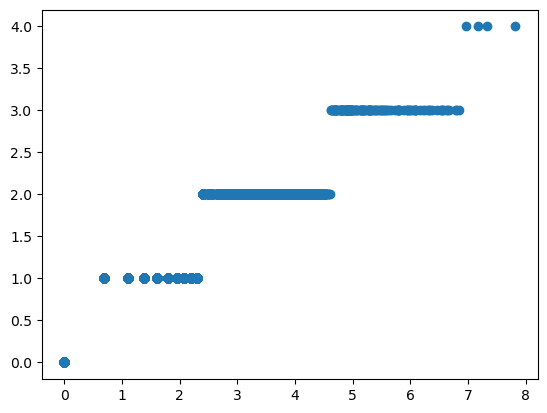

In [25]:
plt.scatter(ensemble_test_df['ln_ged_sb_dep'],ensemble_test_df['ged_multi'])

In [26]:
for step in steps:
    if ensemble_test_df[f'step_pred_{step}'].isnull().sum().sum() != 0:
        print('****WARNING***** - detected',ensemble_test_df[f'step_pred_{step}'].isnull().sum().sum(),'Nan(s) in column step_pred_'+str(step))
        print('Replacing with zeros')
        ensemble_test_df[f'step_pred_{step}']=ensemble_test_df[f'step_pred_{step}'].fillna(0.0)

In [27]:
# Train model to transform predictions from  fatalities to (1) dichotomous and (2) multiclass
from sklearn.linear_model import LogisticRegression
dichotomous_classifiers = []
multi_classifiers = []
for step in steps:
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Dichotomous
    y_dich = np.array(ensemble_test_df['ged_gte_25']).reshape(-1, 1)
    dich_clf = LogisticRegression(random_state=0).fit(X, y_dich)
    dichotomous_classifiers.append(dich_clf)
    p_dich = dich_clf.predict_proba(X)
    ensemble_test_df['dich_step_{step}_logit'] = p_dich[:,1].ravel()
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    p_multi = multi_clf.predict_proba(X)
    for cls in [0,1,2,3,4]:
        ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()

ensemble_test_df.describe()

/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was 

/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jim/miniconda3/envs/viewser/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was 

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly f

/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()
/var/folders/yx/jx4m7bqx0m96x8cnzd8175kh0000gn/T/ipykernel_50024/2360434821.py:20: PerformanceWarning: DataFrame is highly f

,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,step_pred_10,...,multi_0_step_35_logit,multi_1_step_35_logit,multi_2_step_35_logit,multi_3_step_35_logit,multi_4_step_35_logit,multi_0_step_36_logit,multi_1_step_36_logit,multi_2_step_36_logit,multi_3_step_36_logit,multi_4_step_36_logit
count,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,629280.0,...,6.292800e+05,6.292800e+05,6.292800e+05,6.292800e+05,6.292800e+05,6.292800e+05,6.292800e+05,6.292800e+05,6.292800e+05,6.292800e+05
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.221246e-15,1.734725e-18,3.903131e-18,2.710508e-19,3.388134e-21,1.221246e-15,1.734725e-18,3.903131e-18,2.710508e-19,3.388134e-21
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06,9.919956e-01,5.320374e-03,2.458364e-03,2.193024e-04,6.355555e-06


In [28]:
EnsembleList[0]['future_df_dichotomous'] = EnsembleList[0]['predictions_future_df'].copy() # Copy from baseline

for step in steps:
    month = EndOfHistory + step
#    weightcol = 'step_pred_' + str(step)
#    weights = np.array(pd.DataFrame(i_weights_df[weightcol]))
#    EnsembleList[0]['future_df_calibrated'].loc[month] = ConstituentModels_df_w.loc[month].dot(weights).values
    x_d = np.array(EnsembleList[0]['predictions_future_df'].loc[month]).reshape(-1,1)
    pred_step = dichotomous_classifiers[step-1].predict_proba(x_d)
    EnsembleList[0]['future_df_dichotomous']['step_combined'].loc[month] = pred_step[:,1]

In [29]:
predstore_future_dich = level +  '_' + EnsembleList[0]['modelname'] + '_dich_f' + str(EndOfHistory)
EnsembleList[0]['future_df_dichotomous'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_dichotomous'].forecasts.to_store(name=predstore_future_dich, overwrite = True) 

# Mapping future predictions

In [30]:
# get pgm geometries
gdf_base = gpd.read_parquet('../Tools/geometry/pgm_geometry.parquet')

In [31]:
# get cm geometries
gdf_c = gpd.read_parquet('../Tools/geometry/cm_geometry.parquet')
gdf_c = gdf_c.to_crs(4326)

In [32]:
df_with_wanted_index=Datasets[0]['df']

index_check(EnsembleList[0],df_with_wanted_index)

Repairing index in  predictions_calib_df from ensemble_cm_calib
original: month_id priogrid_id
fixed: month_id priogrid_gid
Repairing index in  predictions_test_df from ensemble_cm_calib
original: month_id priogrid_id
fixed: month_id priogrid_gid
Repairing index in  predictions_future_df from ensemble_cm_calib
original: month_id priogrid_id
fixed: month_id priogrid_gid
Repairing index in  future_df_dichotomous from ensemble_cm_calib
original: month_id priogrid_id
fixed: month_id priogrid_gid


In [33]:
# Future prediction maps, predictions, rolling
#path = Mydropbox + 'Projects/PredictingFatalities/maps/cm_future/'
stepstoplot=[3,5,6,8,12,18,24,36]
#titles = [vid2date(i) for i in stepstoplot + EndOfHistory]


df = Ensemble['predictions_future_df'].copy()
gdf2 = gdf_base.copy()
df = df.join(gdf2.set_index("priogrid_gid"))
gdf3 = gpd.GeoDataFrame(df, geometry="geom")

In [65]:
df.describe()

,step_combined
count,471960.000000
mean,0.096832
std,0.350701
min,0.000015
25%,0.000859
50%,0.003524
75%,0.022967
max,5.834877


In [34]:
path = Mydropbox + 'Projects/PredictingFatalities/Predictions/pgm/preds/'

In [66]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf,
#        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
#        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=0.7,facecolor='None')
        
#        m.cbar.set_ticks(standard_scale)
#        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

In [ ]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[29.446846321370213, 50.987309710685814, 1.1561557161401845, 18.29970129951559], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=m.fig
        fontdict={'fontsize':20}
        figure.text(0.4,0.45,'ETHIOPIA',fontdict=fontdict,color='black')
        figure.text(0.2,0.7,'SUDAN',fontdict=fontdict,color='black')
        figure.text(0.15,0.35,'S. SUDAN',fontdict=fontdict,color='black')
        figure.text(0.65,0.5,'SOMALIA',fontdict=fontdict,color='black')
        figure.text(0.35,0.25,'KENYA',fontdict=fontdict,color='black')
        
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_Ethiopia_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

In [ ]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-2.3019466946294584, 20.374695512438592, 1.103974761908613, 16.794164972712068], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.2,
        column='step_combined', 
        inform_colorbar=True
        )
        ax=m.ax
        fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=m.fig
        fontdict={'fontsize':20}
        figure.text(0.4,0.45,'NIGERIA',fontdict=fontdict,color='black')
        figure.text(0.4,0.7,'NIGER',fontdict=fontdict,color='black')
        figure.text(0.5,0.35,'CAMEROON',fontdict=fontdict,color='black')
        figure.text(0.7,0.60,'CHAD',fontdict=fontdict,color='black')
        figure.text(0.7,0.4,'C.A.R.',fontdict=fontdict,color='black')
        figure.text(0.15,0.60,'B. FASO',fontdict=fontdict,color='black')
        
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)

#        m.save(f'{overleafpath}Figures/Future/PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

        m.save(f'{path}PredictionMap_Nigeria_pgm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

# Changes to 3- and 6-month forecasts, and since last actual observation


In [ ]:
# Reading in data for mapping
# Predictions now and then
predstore_then = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory-3)

df_now = EnsembleList[0]['predictions_future_df'].copy()

df_then=ViewsMetadata().with_name('ensemble_cm_calib_f'+str(EndOfHistory-3)).fetch()

try:
    df_then = pd.DataFrame.forecasts.read_store(run=run_id, name=predstore_then)
except:
    print('Trouble reading forecasts issued three months ago')
    
# Actuals

df_lastobserved = Datasets[0]['df']

In [ ]:
# Compute log of mean non-logged fatalities, past six months
df_observed = df_lastobserved.loc[EndOfHistory]
df_observed['ged_sb_0'] = np.expm1(df_observed['ln_ged_sb'])
df_observed['ged_sum'] = df_observed['ged_sb_0']
for t in [1,2,3,4,5]:
    colname = 'ged_sb_' + str(t)
    df_observed[colname] = np.expm1(df_lastobserved.loc[EndOfHistory-t]['ln_ged_sb'])
    df_observed['ged_sum'] = df_observed['ged_sum'] + df_observed[colname]
df_observed['ln_ged_sum'] = np.log1p(df_observed['ged_sum']/6)
#df_observed.tail(20)

In [ ]:
StepsForward = [
{
    'Step': 3,
    'df_now': df_now.loc[EndOfHistory + 3],
    'df_then': df_then.loc[EndOfHistory - 3 + 3]
},
{
    'Step': 6,
    'df_now': df_now.loc[EndOfHistory + 6],
    'df_then': df_then.loc[EndOfHistory - 3 + 6]
},
]
engine = sa.create_engine(source_db_path)
#predictors_df = data_vdem_short.loc[EndOfHistory]
#predictors_df_3m = data_vdem_short.loc[EndOfHistory-3]

for s in StepsForward:
    s['df_now'].rename(columns={'step_combined':'Now'}, inplace=True)
    s['df_then'].rename(columns={'step_combined':'Then'}, inplace=True)
    s['df'] = pd.concat([s['df_now'],s['df_then'],df_observed['ln_ged_sum']],axis=1)
    s['df']['Change_in_prediction'] = s['df']['Now']-s['df']['Then']
    s['df']['Change_since_last_observed'] = s['df']['Now']-s['df']['ln_ged_sum']
    
#    # Surrogate model change
#    for sm in SurrogateModelList:
#        if sm['Step'] == s['Step']:
#            s['sdf'] = predictors_df[sm['Columns']]
#            s['sdf'][sm['Predcolname']] = sm['GAM'].predict(predictors_df[sm['Columns']])
#            s['sdf_3m'] = predictors_df_3m[sm['Columns']]
#            s['sdf_3m'][sm['Predcolname']] = sm['GAM'].predict(predictors_df_3m[sm['Columns']])
#            print(sm['Step'],sm['Predcolname'])
#            dfcolname = sm['Predcolname'][:-2] + '_ch3m'
#            s['df'][dfcolname] = s['sdf'][sm['Predcolname']] - s['sdf_3m'][sm['Predcolname']]
    
    s['gdf'] = gdf_base
    s['gdf'] = s['gdf'].to_crs(4326)

    s['gdf_t'] = s['df'].join(s['gdf'].set_index("priogrid_gid"))
    s['gdf'] = gpd.GeoDataFrame(s['gdf_t'], geometry="geom")
    
    
StepsForward[0]['gdf'].describe()

In [ ]:
tickvalues = np.array([-80,-50,-20,0,20,50,100,200,500])
print(tickvalues)
ticklabels=[str(tv) for tv in tickvalues]
tickvalues = np.log((100+tickvalues)/100)
print(tickvalues)

In [ ]:
path= Mydropbox + f'DataReleases/MonthlyUpdates/{run_id}_{prod_id}/Continuous/Ensemble/ChangeMaps/'

In [ ]:
delta = 3

tickvalues=np.array([-300,-30,-3,3,30,300])
ticklabels=[str(tv) for tv in tickvalues]

tickvalues=np.sign(tickvalues)*np.log1p(np.abs(tickvalues)+1)
#print(tickvalues)
tickvalues = np.array([-83,-80,-50,-20,0,20,50,100,200,500])
ticklabels=[str(tv) for tv in tickvalues]
ticklabels[0] = ""
tickvalues = np.log((100+tickvalues)/100)


t0s=range(508,509) # From start of month A, to start of (but not including) month B
bbox="africa_middle_east"
cmap='bwr'#'rainbow'
for s in StepsForward:
    for column in ['Change_in_prediction','Change_since_last_observed']:
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title=f"{column}, s= {s['Step']}",
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=s['gdf'],
        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=column, 
        inform_colorbar=True
        )
        m.cbar.set_ticks(surrogate_scale)
        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(path+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
#        if WriteToOverleaf:
#            plot.save(overleafpath+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
        